# Google Drive Interface Setup

In [1]:
from google.colab import drive, auth
import sys

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Pull down github repo, store in colab runtime memory
!git clone https://github.com/andrew-loeber/proj_utils_207.git

Cloning into 'proj_utils_207'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (34/34), 8.72 KiB | 2.91 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:
# Tell Python to also look in this repo when running an import
sys.path.insert(1, "/content/proj_utils_207")

In [5]:
# Authenticate google account and give back the session access token
auth.authenticate_user()
gcloud_token = !gcloud auth print-access-token
gcloud_token

['ya29.a0AbVbY6NItqaQwwNiUfn0oekYaeuQ2aJiBhG9tcq9fmWkH7ATI2DTD0A-zu0_ZL78fL90ryA4TIOh_CG6cenh1wtb58EGn9LeRYXsvkpEaGV9jTXulaxYWLww1z8-CCHTa-Sy2j8Wndkt6OIewwH2iFgvCt1CaCgYKATcSARESFQFWKvPlfjOz9rlRteTihHeWyrImuQ0163']

In [6]:
from gdriveinterface import GDriveInterface
import proj_ref

In [7]:
# Show email address, username, and the path of the shared project folder on
# your Google Drive instance
gdi = GDriveInterface(gcloud_token)
shared_folder_path = gdi.shared_folder_path
gdi.__dict__

{'email': 'aloeber@berkeley.edu',
 'account': 'aloeber',
 'shared_folder_path': '/content/drive/MyDrive/207-Project'}

In [8]:
# Show name keys and paths for tracked files
proj_ref.files

{'taxonomy': 'BirdCLEF/eBird_Taxonomy_v2021.csv',
 'orig_metadata': 'BirdCLEF/train_metadata_with_duration.csv',
 'sample_metadata': 'data/sample_metadata.csv',
 'species_metadata': 'data/species_metadata.csv',
 'train_metadata': 'data/train_metadata.csv',
 'test_metadata': 'data/test_metadata.csv'}

In [9]:
# Show name keys and paths for tracked directories
proj_ref.dirs

{'orig_audio': {'path': 'BirdCLEF/train_audio'},
 'train_audio': {'path': 'data/train/audio_files'},
 'test_audio': {'path': 'data/test/audio_files'},
 'train_npy_full': {'path': 'data/train/librosa_loaded'},
 'test_npy_full': {'path': 'data/test/librosa_loaded'},
 'train_npy_loud5s': {'path': 'data/train/librosa_loaded_loudest_5sec'},
 'test_npy_loud5s': {'path': 'data/test/librosa_loaded_loudest_5sec'}}

### **Usage examples**

##### Query specific file based on named key
```
command: gdi.get_file_path('taxonomy')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/eBird_Taxonomy_v2021.csv'
```

##### Query specific directory based on named key
```
command: gdi.get_dir_path('orig_audio')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/train_audio'
```

##### Query specific sample record based on named keys for directory and file
```
command: gdi.get_sample_path('train_audio', 'barswa/XC132406.ogg')
returns: '/content/drive/MyDrive/207-Project/data/train/audio_files/barswa/XC132406.ogg'
```

##### Provide full path given a custom partial path
```
command: gdi.join_to_shared('images/sandpiper.jpeg')
returns: '/content/drive/MyDrive/207-Project/images/sandpiper.jpeg'
```


# Imports and Setup

In [10]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.0 MB/s eta 0:00:00


In [11]:
!pip install colorednoise

In [12]:
# !pip install tensorflow-addons

In [13]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
# import tensorflow_addons as tfa
import librosa
from IPython.display import Audio
import audiomentations as am
import colorednoise as cn
import gc

In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Read in metadata, audio files, frames, & labels

In [15]:
train_file_df = pd.read_csv(
    gdi.join_to_shared('3_species/train/file_df.csv')
)
train_file_df

,data,primary_label,primary_label_enc,filename,filename_npy,rating,type,type_enc,country,country_enc,continent,continent_enc,file_duration_s,file_duration_samples
0,train,comsan,1,comsan/XC746957.ogg,comsan/XC746957.npy,good,blank,0,DK,15,EUROPE,3,6.112000,97792
1,train,eaywag1,2,eaywag1/XC658750.ogg,eaywag1/XC658750.npy,good,call,2,DE,14,EUROPE,3,49.680000,794880
2,train,comsan,1,comsan/XC725160.ogg,comsan/XC725160.npy,good,blank,0,EE,16,EUROPE,3,6.635000,106160
3,train,comsan,1,comsan/XC430908.ogg,comsan/XC430908.npy,good,call,2,RU,46,EUROPE,3,15.255500,244088
4,train,eaywag1,2,eaywag1/XC507677.ogg,eaywag1/XC507677.npy,poor,call,2,GB,20,EUROPE,3,17.397562,278361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,train,comsan,1,comsan/XC432940.ogg,comsan/XC432940.npy,good,call,2,NL,41,EUROPE,3,12.408000,198528
653,train,comsan,1,comsan/XC199825.ogg,comsan/XC199825.npy,good,call,2,ES,17,EUROPE,3,8.376000,134016
654,train,eaywag1,2,eaywag1/XC687206.ogg,eaywag1/XC687206.npy,good,call,2,IE,26,EUROPE,3,152.633000,2442128
655,train,eaywag1,2,eaywag1/XC591908.ogg,eaywag1/XC591908.npy,good,call,2,PL,44,EUROPE,3,14.616000,233856


In [16]:
train_labels = np.load(gdi.join_to_shared('3_species/train/file_labels.npy'))
train_labels[0:5]

array([1, 2, 1, 1, 2])

In [17]:
train_labels.shape

(657,)

In [18]:
# train_frames = np.load(gdi.join_to_shared('3_species/train/frames.npy'))
# train_frames[0:5]

In [19]:
# train_frames.shape

In [20]:
train_files_filepath = gdi.join_to_shared('3_species/train/files.pkl')
with open(train_files_filepath, 'rb') as file:
  train_files = pkl.load(file)
train_files[0:5]

[array([ 5.9499580e-06, -1.0428121e-05, -2.0700150e-05, ...,
        -1.4326214e-02, -1.2398371e-02, -1.4604669e-02], dtype=float32),
 array([-1.1132361e-06,  4.6719542e-06, -4.7960584e-06, ...,
        -7.4155294e-05, -4.1194289e-07,  9.1129157e-05], dtype=float32),
 array([-2.3218287e-05, -7.0027181e-06,  2.3201643e-05, ...,
        -6.9095149e-06, -2.1964188e-06,  5.6537119e-06], dtype=float32),
 array([ 1.0609627e-05,  4.7013164e-06,  6.1467290e-07, ...,
        -7.4523976e-03, -9.0304529e-03, -1.1077991e-02], dtype=float32),
 array([ 1.00838915e-05, -1.91047661e-06,  2.31165677e-06, ...,
        -9.90291737e-05,  2.73336598e-04, -1.12968672e-04], dtype=float32)]

In [34]:
train_files = [file - np.mean(file) for file in train_files.copy()]
train_files[0:5]

[array([ 0.00204584,  0.00202946,  0.00201919, ..., -0.01228633,
        -0.01035848, -0.01256478], dtype=float32),
 array([-1.1120907e-06,  4.6730997e-06, -4.7949129e-06, ...,
        -7.4154152e-05, -4.1079747e-07,  9.1130300e-05], dtype=float32),
 array([-2.3099887e-05, -6.8843183e-06,  2.3320043e-05, ...,
        -6.7911151e-06, -2.0780190e-06,  5.7721118e-06], dtype=float32),
 array([ 6.4127235e-05,  5.8218928e-05,  5.4132284e-05, ...,
        -7.3988801e-03, -8.9769354e-03, -1.1024473e-02], dtype=float32),
 array([ 1.0048502e-05, -1.9458657e-06,  2.2762677e-06, ...,
        -9.9064564e-05,  2.7330121e-04, -1.1300406e-04], dtype=float32)]

In [23]:
train_sizes = np.array(train_file_df['file_duration_samples'])
train_sizes[0:10]

array([  97792,  794880,  106160,  244088,  278361,  325172, 1077081,
        461568,  714704, 4829519])

In [24]:
train_durations = np.array(train_file_df['file_duration_s'])
train_durations[:10]

array([  6.112     ,  49.68      ,   6.635     ,  15.2555    ,
        17.3975625 ,  20.32325   ,  67.3175625 ,  28.848     ,
        44.669     , 301.84490625])

In [25]:
# train_sample_wts = np.array([ ((dur - 5.0) / 2.5) + 1 for dur in train_durations ])
# train_sample_wts /= np.mean(train_sample_wts)
# train_sample_wts

In [26]:
# train_sample_weights = np.array(train_file_df['file_duration_s'])
# train_sample_weights /= np.mean(train_sample_weights)
# train_sample_weights[0:10]

In [27]:
val_frame_df = pd.read_csv(
    gdi.join_to_shared('3_species/val/frame_df.csv')
)
val_frame_df

,data,primary_label,primary_label_enc,filename,filename_npy,rating,type,type_enc,country,country_enc,continent,continent_enc,file_duration_s,file_duration_samples,frame_length_s,hop_length_s,total_frames,frame_id
0,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,1
1,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,2
2,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,3
3,val,comsan,1,comsan/XC669042.ogg,comsan/XC669042.npy,good,call,2,HR,23,EUROPE,3,14.367000,229872,5.0,2.5,4,4
4,val,barswa,0,barswa/XC57672.ogg,barswa/XC57672.npy,good,song,3,UNKNOWN,55,UNKNOWN,4,40.960000,655360,5.0,2.5,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,19
3117,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,20
3118,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,21
3119,val,barswa,0,barswa/XC184418.ogg,barswa/XC184418.npy,good,both,1,KZ,34,ASIA,2,60.473469,967576,5.0,2.5,23,22


In [28]:
val_frame_labels = np.load(gdi.join_to_shared('3_species/val/frame_labels.npy'))
val_frame_labels[0:5]

array([1, 1, 1, 1, 0])

In [29]:
val_frame_labels.shape

(3121,)

In [30]:
val_frames = np.load(gdi.join_to_shared('3_species/val/frames.npy'))
val_frames[0:5]

array([[-2.70812802e-06,  2.27731789e-06,  6.10671464e-07, ...,
         4.44087666e-04, -1.34347146e-02,  4.17729001e-03],
       [ 1.13037531e-03,  4.36404441e-03,  5.12790517e-04, ...,
        -3.71276285e-04,  3.11362371e-03, -1.08309905e-03],
       [ 1.22987926e-02, -7.29914336e-03, -5.96568920e-03, ...,
        -2.97210005e-04, -2.47759186e-03, -2.29351601e-04],
       [ 1.11260731e-03,  3.40224011e-04, -8.38086358e-04, ...,
         2.87609873e-03, -4.81321616e-03,  1.80263212e-03],
       [ 3.00267129e-06, -6.75930642e-06, -2.86684372e-06, ...,
        -1.03749875e-02, -9.73683130e-03, -7.67644681e-03]], dtype=float32)

In [31]:
val_frames.shape

(3121, 80000)

# Define helper functions

In [37]:
def get_random_clip(
    audio
    , rng
    , clip_len=80000
    ):
  audio_len = len(audio)
  clip_start = rng.integers(audio_len - clip_len)
  clip_locs = (clip_start, clip_start + clip_len)
  return audio[clip_locs[0] : clip_locs[1]].copy()


In [38]:
def audio_to_stft(
    audio
    , n_fft=128
    , hop_length=64):

  S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
  S = np.abs(S)
  S_min, S_max = np.min(S), np.max(S)
  S_range = S_max - S_min
  return (S - S_min) / S_range

In [39]:
def audio_to_db_stft(
    audio
    , n_fft=128
    , hop_length=64):

  S = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
  S = np.abs(S)
  S = librosa.amplitude_to_db(S, ref=np.max)
  S -= np.mean(S)
  S /= np.std(S)
  return S

In [41]:
def transform_frames(frames, transform, transform_args):
  return np.array([transform(frame.copy(), **transform_args) for frame in frames])

def transform_frame(frame, transform, transform_args):
  return transform(frame.copy(), **transform_args)

In [42]:
def audio_compress(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_compress(samples, mu=mu, quantize=False)

def audio_expand(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_expand(samples, mu=mu, quantize=False)

def add_silent_frames(samples, sample_rate, p_min=5e-5, p_max=1e-2):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=1-prob, size=len(samples))
  return (mask * samples).astype(np.float32)

def add_crackle(samples, sample_rate, p_min=1e-5, p_max=2e-4):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=prob, size=len(samples))
  noise = np.random.binomial(n=1, p=0.5, size=len(samples)) * 2 - 1
  return np.where(mask, noise, samples).astype(np.float32)

def add_colored_noise(
    samples
    , sample_rate
    , exp_min=-4
    , exp_max=2
    , scale_min=0.005
    , scale_max=0.025
    ):
  exp = np.random.uniform(low=exp_min, high=exp_max)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = cn.powerlaw_psd_gaussian(exp, size=len(samples))
  return samples + (scale * noise)

def add_colored_noise2(
    samples
    , sample_rate
    , min_gain_db=-18.0
    , max_gain_db=18.0
    , scale_min=0.005
    , scale_max=0.05
    ):
  eq = am.SevenBandParametricEQ(
      min_gain_db=min_gain_db
      , max_gain_db=max_gain_db
      , p=1.0
  )
  norm = am.Normalize(p=1.0)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = np.random.randn(len(samples))
  noise = eq(noise, sample_rate=sample_rate)
  noise = norm(noise, sample_rate=sample_rate)
  return samples + (scale * noise)

# Processing

In [37]:
%who

Audio	 GDriveInterface	 add_colored_noise	 add_colored_noise2	 add_crackle	 add_silent_frames	 am	 audio_compress	 audio_expand	 
audio_to_db_stft	 audio_to_stft	 auth	 cn	 drive	 file	 gc	 gcloud_token	 gdi	 
get_random_clip	 layers	 librosa	 np	 pd	 pkl	 plt	 proj_ref	 shared_folder_path	 
sns	 sys	 tf	 train_durations	 train_file_df	 train_files	 train_files_filepath	 train_labels	 train_sizes	 
transform_frame	 transform_frames	 val_frame_df	 val_frame_labels	 val_frames	 


In [43]:
gc.collect()

0

In [44]:
transform = audio_to_db_stft
transform_args = {'n_fft': 64, 'hop_length': 64}

In [45]:
val_features = transform_frames(val_frames, transform, transform_args)
val_features.shape

(3121, 33, 1251)

In [42]:
# del val_frames

In [46]:
gc.collect()

35757

In [44]:
# plt.figure(figsize=(18,4))
# librosa.display.specshow(
#     val_features[1052,:,:]
#     , x_axis='time'
#     , y_axis='linear'
#     , sr=16000
#     , hop_length=64
# )

In [47]:
aug = am.Compose([
    # am.PitchShift(-2, 2, 0.25)
    # , am.Shift(-0.15, 0.15, False, p=1.0)
    am.Normalize(p=1.0)
    , am.OneOf([
        am.Lambda(transform=audio_compress, mu_min=1, mu_max=7, p=0.3)
        , am.Lambda(transform=audio_expand, mu_min=1, mu_max=11, p=0.3)
    ])

    , am.PeakingFilter(100, 2000, -12, 12, 1.0, 5.0, p=0.35)
    , am.PeakingFilter(2000, 4000, -12, 12, 1.0, 5.0, p=0.35)
    , am.PeakingFilter(4000, 6000, -12, 12, 1.0, 5.0, p=0.35)
    , am.PeakingFilter(6000, 7500, -12, 12, 1.0, 5.0, p=0.35)
    , am.LowPassFilter(4000, 7000, 6, 18, p=0.35)
    , am.HighPassFilter(100, 2000, 6, 18, p=0.35)

    , am.TimeMask(0.01, 0.1, p=0.5)
    , am.TimeMask(0.01, 0.1, p=0.5)
    , am.TimeMask(0.01, 0.1, p=0.5)
    , am.TimeMask(0.01, 0.1, p=0.5)
    , am.TimeMask(0.01, 0.1, p=0.5)

    , am.Lambda(
        transform=add_colored_noise2
        , min_gain_db=-15.0
        , max_gain_db=15.0
        , scale_min=0.005
        , scale_max=0.1
        , p=0.65
    )

    # , am.PeakingFilter(1000, 7000, -50, -38, 1, 2, 0.5)

    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_silent_frames, p=0.2)
    , am.Lambda(transform=add_crackle, p=0.2)
])

In [48]:
sample_audio_num = 1055
val_frame_df.iloc[sample_audio_num]

data                                     val
primary_label                         barswa
primary_label_enc                          0
filename                 barswa/XC457823.ogg
filename_npy             barswa/XC457823.npy
rating                                  good
type                                    call
type_enc                                   2
country                                   RU
country_enc                               46
continent                             EUROPE
continent_enc                              3
file_duration_s                       28.176
file_duration_samples                 450816
frame_length_s                           5.0
hop_length_s                             2.5
total_frames                              10
frame_id                                   2
Name: 1055, dtype: object

In [49]:
sample_audio = val_frames[sample_audio_num]
sample_audio

array([-0.00083433, -0.02356659,  0.00866812, ..., -0.00054706,
        0.00162184,  0.00188546], dtype=float32)

In [50]:
Audio(sample_audio, rate=16000, autoplay=True)

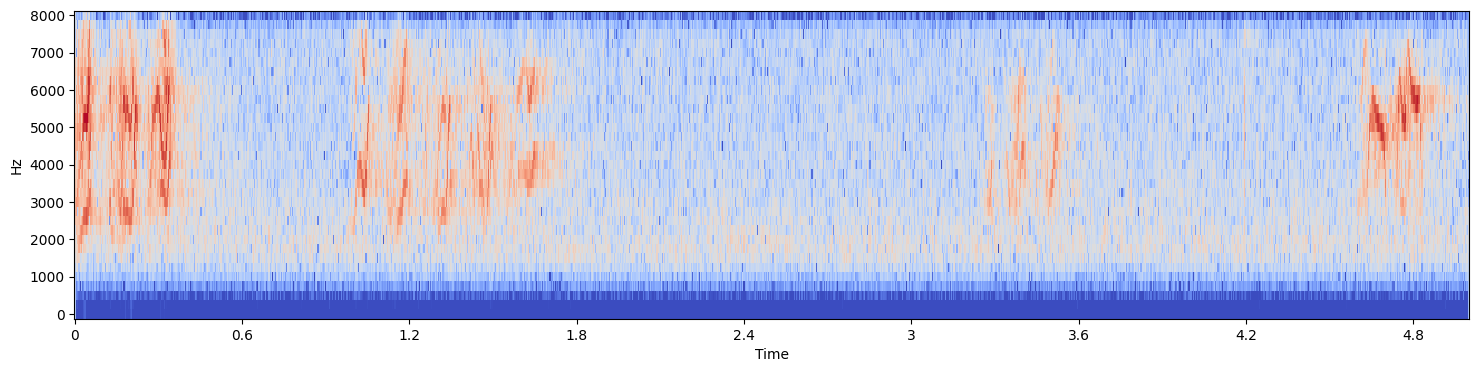

In [51]:
sample_spec = transform_frame(sample_audio, transform, transform_args)
# sample_spec = audio_to_db_stft(sample_audio, n_fft=128, hop_length=64)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

In [80]:
#sample_audio_aug = am.LowPassFilter(200, 4000, 12, 24, p=1.0)(sample_audio, 16000)
sample_audio_aug = aug(sample_audio, 16000)
Audio(sample_audio_aug, rate=16000, autoplay=True)

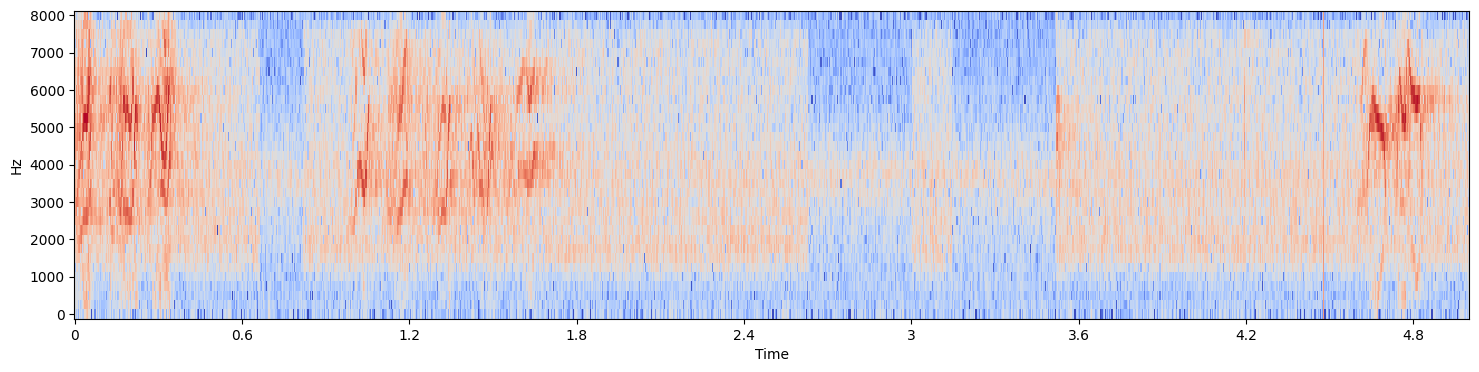

In [81]:
sample_spec_aug = transform_frame(sample_audio_aug, transform, transform_args)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec_aug
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

# Define audio sequence

In [85]:
class AudioSequence(tf.keras.utils.Sequence):
  def __init__(self
               , x
               , y
               , batch_size
               , feature_transform
               , feature_transform_args
               , durations=None
               , augmentation=None
               , shuffle=True
               , seed=42):
    self.x, self.y, self.durations = x, y, durations
    self.data_length = len(y)
    self.sample_wts = self._get_sample_weights()
    self.batch_size = batch_size

    self.augmentation = augmentation
    self.feature_transform = feature_transform
    self.feature_transform_args = feature_transform_args.copy()

    self.shuffle = shuffle
    self.indices = np.arange(self.data_length)
    self.rng = np.random.default_rng(seed=seed)
    if self.shuffle:
      self.rng.shuffle(self.indices)

  def __len__(self):
    return self.data_length // self.batch_size

  def _get_sample_weights(self):
    if self.durations is None:
      return np.ones(self.data_length)
    else:
      wts = np.array([ 1.0 - (5.0 / dur) for dur in self.durations ])
      #wts = np.array([ ((dur - 5.0) / 2.5) + 1 for dur in self.durations ])
      wts /= np.mean(wts)
      return wts

  def __getitem__(self, idx):
    batch_indexes = self.indices[
        idx * self.batch_size : (idx + 1) * self.batch_size
    ]
    x_batch = [self.x[i] for i in batch_indexes]
    x_batch = transform_frames(
        x_batch, get_random_clip, {'rng': self.rng}
    )
    if self.augmentation:
      x_batch = transform_frames(
          x_batch, self.augmentation, {'sample_rate': 16000}
      )
    x_fts = transform_frames(
        x_batch
        , self.feature_transform
        , self.feature_transform_args
    )
    y_labels = self.y[batch_indexes]
    wts = self.sample_wts[batch_indexes]

    return x_fts, y_labels, wts

  def on_epoch_end(self):
    if self.shuffle:
      self.rng.shuffle(self.indices)
    gc.collect()


In [86]:
BATCH_SIZE = 32

train_seq = AudioSequence(
    x=train_files
    , y=train_labels
    , batch_size=BATCH_SIZE
    , feature_transform=transform
    , feature_transform_args=transform_args
    , durations=train_durations
    , augmentation=aug
    , shuffle=True
    , seed=42
)

In [240]:
train_seq_it = train_seq.__iter__()

In [241]:
next(train_seq_it)

(array([[[ 0.3389088 ,  0.9806713 ,  0.54108924, ..., -0.09471491,
           0.12846121, -0.71266454],
         [ 0.49855617,  1.3759217 ,  1.2178158 , ...,  0.4636731 ,
           1.1393782 ,  0.7988499 ],
         [ 0.9026041 ,  1.8845031 ,  1.6565017 , ...,  0.8209052 ,
           1.7054495 ,  1.2381847 ],
         ...,
         [ 0.14326225,  0.51028633,  0.6073716 , ..., -0.2609821 ,
           0.64080244,  0.4143269 ],
         [ 0.19186664,  0.0237482 ,  0.14988597, ...,  0.33903387,
           0.29492852,  0.22887714],
         [ 0.25554448, -0.16213682, -0.77041334, ...,  0.33247268,
          -0.5121155 ,  0.17628087]],
 
        [[ 2.2214143 ,  2.8773465 ,  2.7018414 , ...,  2.8415613 ,
           2.8437405 ,  2.1764493 ],
         [ 2.1262841 ,  3.1021848 ,  2.7129025 , ...,  2.839609  ,
           3.0462809 ,  2.083674  ],
         [ 1.8127644 ,  2.6753497 ,  2.0427053 , ...,  2.3986914 ,
           2.733831  ,  1.7854497 ],
         ...,
         [ 0.65952134,  1.030633 

# Define Additional Layers

In [83]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        cls_randroll = np.random.randn(projection_dim) / 10
        self.cls_token = tf.Variable(
            initial_value=cls_randroll.reshape((1, 1, -1))
            , trainable=True
            , dtype=tf.float32
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        batch_len = tf.shape(patch)[0]
        cls_token_rpt = tf.repeat(self.cls_token, batch_len, axis=0)
        return tf.concat([cls_token_rpt, encoded], axis=-2)

In [84]:
class FFN(layers.Layer):
    def __init__(self, dim, middle_dim, dropout_rate):
        super().__init__()
        self.dim = dim
        self.middle_dim = middle_dim
        self.dropout_rate = dropout_rate
        self.expand = layers.Dense(middle_dim, activation=tf.nn.gelu)
        self.compress = layers.Dense(dim, activation=tf.nn.gelu)
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, patch):
        x = self.expand(patch)
        x = self.dropout(x)
        x = self.compress(x)
        x = self.dropout(x)
        return x

# Define Model

In [159]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(33, 1251))

add_noise = layers.GaussianDropout(rate=0.025)(inputs)

permute1 = layers.Permute((2,1))(add_noise)

add_channel = layers.Reshape(target_shape=(1251, 33, 1))(permute1)

patches0 = tf.image.extract_patches(
    images=add_channel
    , sizes=[1,6,33,1]
    , strides=[1,6,33,1]
    , rates=[1,1,1,1]
    , padding='VALID'
)

patches = layers.Reshape(target_shape=(208, 198))(patches0)
pe = PatchEncoder(208, 64)
patches_enc = pe(patches)

patches_enc_ln = layers.LayerNormalization()(patches_enc)
patches_enc_mha = layers.MultiHeadAttention(
    num_heads=4
    , key_dim=16
    ,dropout=0.1
)(patches_enc_ln, patches_enc_ln)
patches_enc_skip1 = layers.Add()([patches_enc, patches_enc_mha])
patches_enc_ln2 = layers.LayerNormalization()(patches_enc_skip1)
patches_enc_ffn = FFN(64, 96, 0.2)(patches_enc_ln2)
patches_enc_skip2 = layers.Add()([patches_enc_skip1, patches_enc_ffn])

patches_enc_ln_2 = layers.LayerNormalization()(patches_enc_skip2)
patches_enc_mha_2 = layers.MultiHeadAttention(
    num_heads=4
    , key_dim=16
    ,dropout=0.1
)(patches_enc_ln_2, patches_enc_ln_2)
patches_enc_skip1_2 = layers.Add()([patches_enc_skip2, patches_enc_mha_2])
patches_enc_ln2_2 = layers.LayerNormalization()(patches_enc_skip1_2)
patches_enc_ffn_2 = FFN(64, 96, 0.2)(patches_enc_ln2_2)
patches_enc_skip2_2 = layers.Add()([patches_enc_skip1_2, patches_enc_ffn_2])

cls_token_out = layers.Cropping1D(cropping=(0, 208))(patches_enc_skip2_2)
cls_token_out_ln = layers.LayerNormalization()(cls_token_out)
flatten = layers.Flatten()(cls_token_out_ln)
flatten_dropout = layers.Dropout(rate=0.3)(flatten)
preds = layers.Dense(3)(flatten_dropout)


add_noise_m = tf.keras.Model(inputs, add_noise)
patches_m = tf.keras.Model(inputs, patches)

model = tf.keras.Model(inputs, preds)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1251)]   0           []                               
                                                                                                  
 gaussian_dropout (GaussianDrop  (None, 33, 1251)    0           ['input_1[0][0]']                
 out)                                                                                             
                                                                                                  
 permute (Permute)              (None, 1251, 33)     0           ['gaussian_dropout[0][0]']       
                                                                                                  
 reshape (Reshape)              (None, 1251, 33, 1)  0           ['permute[0][0]']          

In [160]:
pe.cls_token

<tf.Variable 'Variable:0' shape=(1, 1, 64) dtype=float32, numpy=
array([[[-9.20705423e-02,  3.75339426e-02, -7.36356676e-02,
         -2.15378910e-01,  5.62275574e-02, -1.58624142e-01,
          1.06789889e-02, -7.58704916e-02, -2.63191760e-02,
          1.75149977e-01, -1.75863102e-01, -6.89645559e-02,
         -2.00170856e-02, -2.63112843e-01,  8.77531171e-02,
         -1.15102798e-01,  1.01628050e-01,  8.30951845e-04,
         -1.45360246e-01, -2.31944788e-02, -1.01787418e-01,
         -1.41100839e-01,  1.77914187e-01,  4.03085398e-03,
         -1.38108954e-01,  6.05970882e-02, -1.18567415e-01,
         -1.52268872e-01, -5.14182039e-02, -5.60847446e-02,
          1.45223930e-01,  3.07090692e-02, -1.20118648e-01,
         -2.16315221e-03,  2.47922037e-02, -4.76938300e-02,
          3.62461619e-02,  2.00075172e-02,  1.22298166e-01,
         -2.23186426e-02,  4.98689748e-02,  6.46143854e-02,
         -1.35374397e-01, -1.75513178e-01,  2.75440700e-02,
          3.94063629e-02, -1.191555

In [161]:
model.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [162]:
model.fit(
    x=train_seq
    , epochs=50
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Epoch 1/50
20/20 [==============================] - 79s 4s/step - loss: 1.4688 - acc: 0.3656 - val_loss: 1.2225 - val_acc: 0.3592
Epoch 2/50
20/20 [==============================] - 67s 3s/step - loss: 1.2170 - acc: 0.4281 - val_loss: 1.0672 - val_acc: 0.4386
Epoch 3/50
20/20 [==============================] - 66s 3s/step - loss: 1.1991 - acc: 0.3844 - val_loss: 1.0417 - val_acc: 0.5319
Epoch 4/50
20/20 [==============================] - 67s 3s/step - loss: 1.0499 - acc: 0.4812 - val_loss: 0.8692 - val_acc: 0.6536
Epoch 5/50
20/20 [==============================] - 67s 3s/step - loss: 0.9056 - acc: 0.5922 - val_loss: 0.6906 - val_acc: 0.7382
Epoch 6/50
20/20 [==============================] - 67s 3s/step - loss: 0.7973 - acc: 0.6469 - val_loss: 0.5845 - val_acc: 0.7482
Epoch 7/50
20/20 [==============================] - 66s 3s/step - loss: 0.7136 - acc: 0.7125 - val_loss: 0.5403 - val_acc: 0.7687
Epoch 8/50
20/20 [==============================] - 65s 3s/step - loss: 0.7087 - acc: 0.70

In [ ]:
history1 = model.history.history.copy()
history1

In [164]:
model.compile(
    #optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9)
     optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4)
    , loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    , metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
    ]
)

In [165]:
model.fit(
    x=train_seq
    , epochs=30
    , validation_data=(val_features, val_frame_labels)
    , validation_batch_size=128
    # , validation_freq=2
    , workers=4
    , use_multiprocessing=True
)

Epoch 1/30
20/20 [==============================] - 79s 4s/step - loss: 0.3211 - acc: 0.8687 - val_loss: 0.3071 - val_acc: 0.8837
Epoch 2/30
20/20 [==============================] - 66s 3s/step - loss: 0.3309 - acc: 0.8844 - val_loss: 0.2966 - val_acc: 0.8866
Epoch 3/30
20/20 [==============================] - 66s 3s/step - loss: 0.3234 - acc: 0.8734 - val_loss: 0.3049 - val_acc: 0.8789
Epoch 4/30
20/20 [==============================] - 67s 3s/step - loss: 0.3209 - acc: 0.8703 - val_loss: 0.3018 - val_acc: 0.8840
Epoch 5/30
20/20 [==============================] - 67s 3s/step - loss: 0.2928 - acc: 0.8750 - val_loss: 0.2996 - val_acc: 0.8850
Epoch 6/30
20/20 [==============================] - 66s 3s/step - loss: 0.3200 - acc: 0.8953 - val_loss: 0.3033 - val_acc: 0.8863
Epoch 7/30
20/20 [==============================] - 65s 3s/step - loss: 0.3315 - acc: 0.8750 - val_loss: 0.2997 - val_acc: 0.8856
Epoch 8/30
20/20 [==============================] - 65s 3s/step - loss: 0.3563 - acc: 0.85

In [ ]:
history2 = model.history.history.copy()
history2

In [177]:
model.save(gdi.join_to_shared('notebooks/AL/models/ViT_1.keras'))

In [180]:
model2 = tf.keras.models.load_model(gdi.join_to_shared('notebooks/AL/models/ViT_1.keras')
  , custom_objects={"PatchEncoder": PatchEncoder, "FFN": FFN}
)

In [186]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1251)]   0           []                               
                                                                                                  
 gaussian_dropout (GaussianDrop  (None, 33, 1251)    0           ['input_1[0][0]']                
 out)                                                                                             
                                                                                                  
 permute (Permute)              (None, 1251, 33)     0           ['gaussian_dropout[0][0]']       
                                                                                                  
 reshape (Reshape)              (None, 1251, 33, 1)  0           ['permute[0][0]']          

In [231]:
patch_enc_m2 = tf.keras.Model(
    inputs=model2.input
    , outputs=model2.get_layer('layer_normalization_4').output
)

In [239]:
model2.get_layer('patch_encoder_1').get_weights()[3]

array([[ 0.04808214, -0.02497224,  0.02779267, ..., -0.08437417,
         0.0118306 , -0.02504291],
       [-0.01145187, -0.02962087,  0.04457357, ...,  0.07873098,
         0.11699288,  0.01071569],
       [-0.00724811,  0.01515337,  0.01124441, ..., -0.01321097,
         0.00043546,  0.06517572],
       ...,
       [ 0.08712531,  0.02741945, -0.02845596, ...,  0.03064393,
         0.09317464, -0.00104974],
       [-0.00391965,  0.0706066 , -0.03613025, ...,  0.00423967,
         0.01406963, -0.04596414],
       [-0.04259229,  0.01450546,  0.00913536, ..., -0.08333138,
         0.11010785,  0.08607494]], dtype=float32)

# Plot History

In [172]:
history = {}

for key in history1.keys():
  history[key] = history1[key] + history2[key]

history

{'loss': [1.4688405990600586,
  1.2169718742370605,
  1.1991482973098755,
  1.049916386604309,
  0.9055607914924622,
  0.7973121404647827,
  0.713614821434021,
  0.7086658477783203,
  0.5961030125617981,
  0.6130120158195496,
  0.5922603607177734,
  0.5389925241470337,
  0.5324088931083679,
  0.5676625967025757,
  0.5163475871086121,
  0.5611761808395386,
  0.5462638735771179,
  0.5692464113235474,
  0.4876313805580139,
  0.4664686322212219,
  0.5102547407150269,
  0.46744734048843384,
  0.51005619764328,
  0.45510753989219666,
  0.4442976117134094,
  0.47167450189590454,
  0.45943719148635864,
  0.42548927664756775,
  0.44448041915893555,
  0.44589799642562866,
  0.46932077407836914,
  0.447488009929657,
  0.43139415979385376,
  0.4008334279060364,
  0.4426569938659668,
  0.5004985332489014,
  0.3951983153820038,
  0.4552769660949707,
  0.40152114629745483,
  0.40629592537879944,
  0.4230819642543793,
  0.37542253732681274,
  0.39369213581085205,
  0.39431267976760864,
  0.40096586942

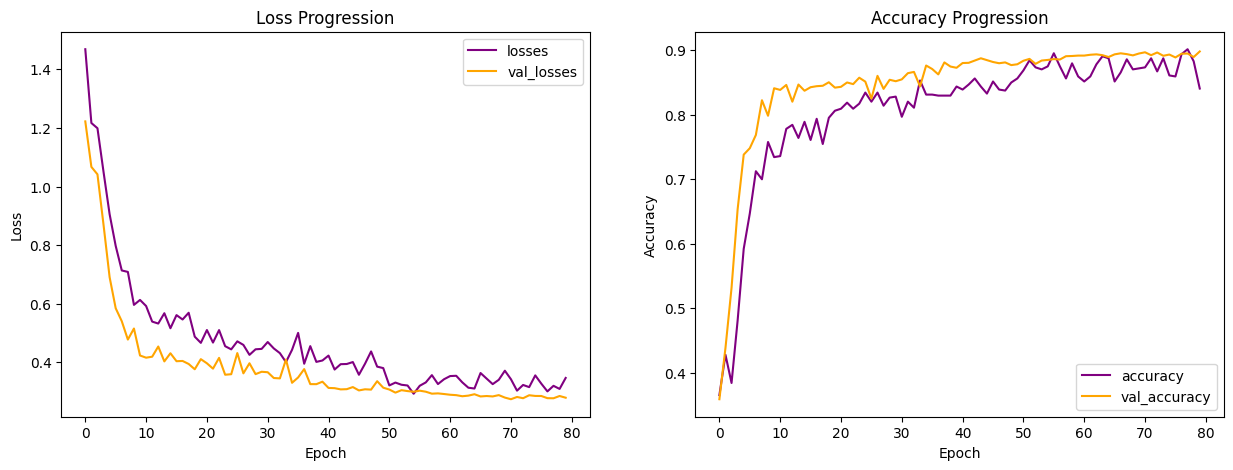

In [173]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

axes[0].plot(history['loss'], color='purple', label='losses')
axes[0].plot(history['val_loss'], color='orange', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(history['acc'], color='purple', label='accuracy')
axes[1].plot(history['val_acc'], color='orange', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()
plt.show()

In [243]:
history_filepath = gdi.join_to_shared('notebooks/AL/models/ViT_1.pkl')
with open(history_filepath, 'wb') as file:
  pkl.dump(history, file)

# See results

In [90]:
sample_audio_num = 1095
sample_audio = val_frames[sample_audio_num]
sample_audio_aug = aug(sample_audio, 16000)
sample_spec = transform_frame(sample_audio, transform, transform_args)
sample_spec_aug = transform_frame(sample_audio_aug, transform, transform_args)

sample_audio_info = val_frame_df.iloc[sample_audio_num]
sample_audio_info

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


data                                      val
primary_label                         eaywag1
primary_label_enc                           2
filename                 eaywag1/XC654684.ogg
filename_npy             eaywag1/XC654684.npy
rating                                   poor
type                                     call
type_enc                                    2
country                                    UZ
country_enc                                57
continent                                ASIA
continent_enc                               2
file_duration_s                        18.886
file_duration_samples                  302176
frame_length_s                            5.0
hop_length_s                              2.5
total_frames                                6
frame_id                                    4
Name: 1095, dtype: object

In [91]:
Audio(sample_audio, rate=16000, autoplay=True)

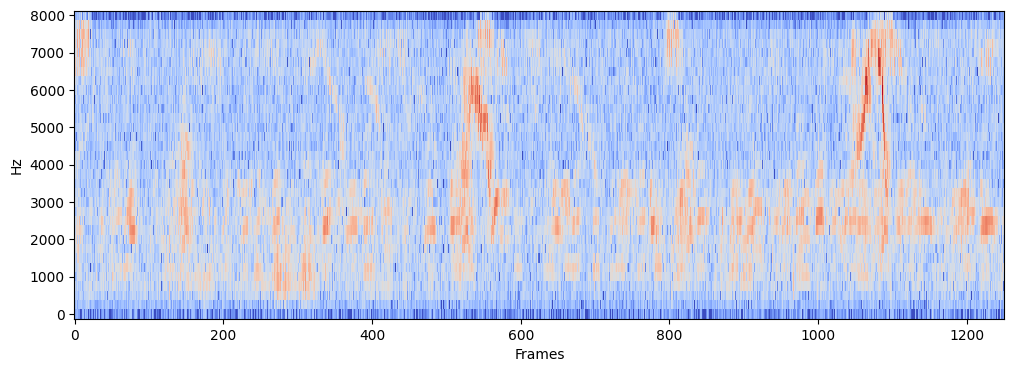

In [103]:
plt.figure(figsize=(12,4))
librosa.display.specshow(
    sample_spec
    , x_axis='frames'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

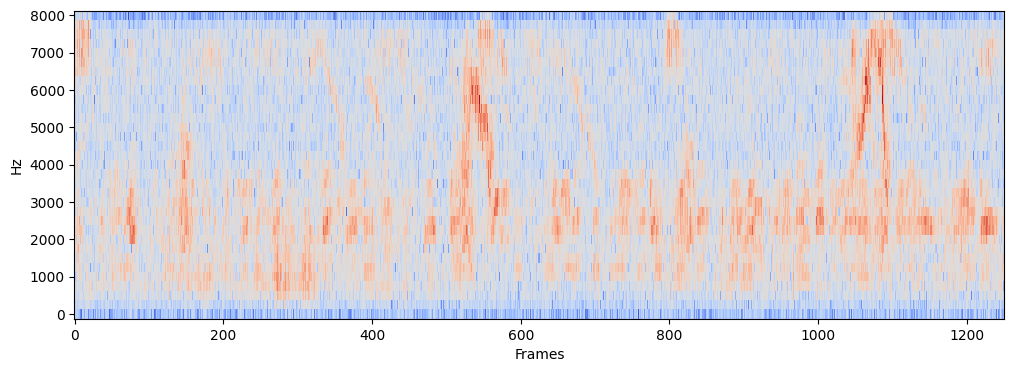

In [158]:
plt.figure(figsize=(12,4))
librosa.display.specshow(
    np.array(tf.squeeze(add_noise_m((np.array([sample_spec])), training=True)))
    , x_axis='frames'
    , y_axis='linear'
    , sr=16000
    , hop_length=64
)

In [276]:
sample_audio_info['primary_label_enc']

2

In [195]:
layers.Softmax()(model2(np.array([sample_spec])))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5.1008686e-03, 7.0565799e-04, 9.9419349e-01]], dtype=float32)>

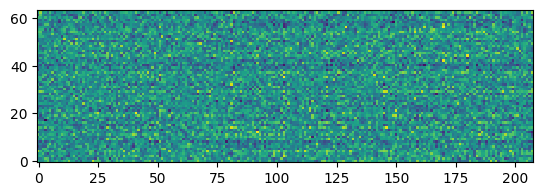

In [242]:
plt.imshow(model2.get_layer('patch_encoder_1').get_weights()[3].T, aspect='equal', origin='lower', interpolation='none')

In [234]:
# lstm_out = tf.squeeze(patch_enc_m2((np.array([sample_spec]))))
lstm_out = patch_enc_m2((np.array([sample_spec])))

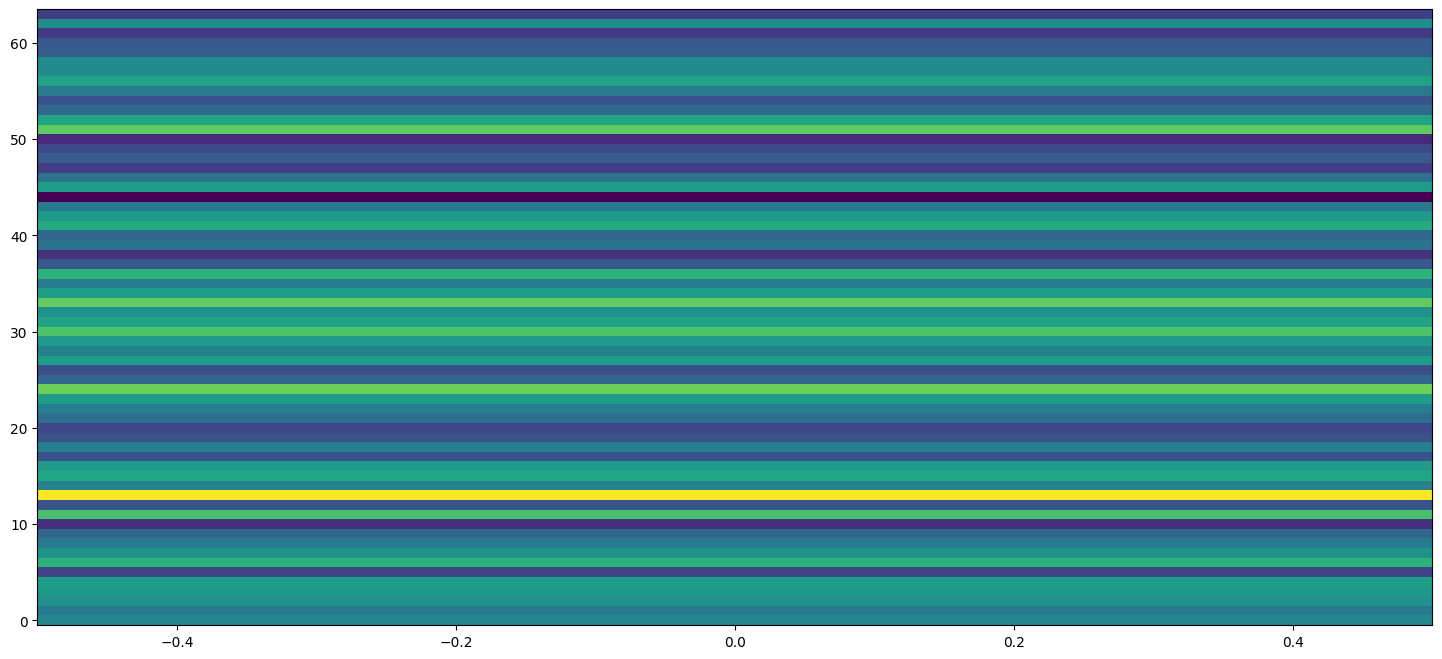

In [235]:
plt.figure(figsize=(18,8))
plt.imshow(np.array(lstm_out).T, aspect='auto', origin='lower', interpolation='none')

In [195]:
dense_out = tf.squeeze(dense_m((np.array([sample_spec_aug]))))

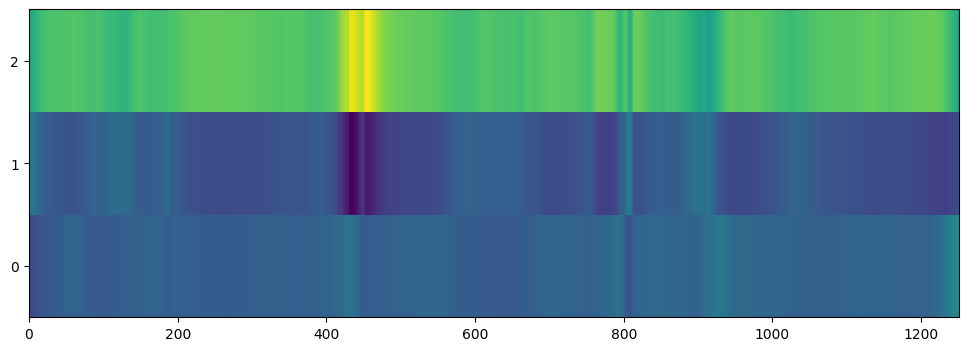

In [196]:
plt.figure(figsize=(12,4))
plt.imshow(np.array(dense_out).T, aspect='auto', origin='lower', interpolation='none')
plt.yticks([0, 1, 2])
plt.show()

In [197]:
mask_out = tf.squeeze(mask_dense_sm_m((np.array([sample_spec_aug]))))

<ipython-input-198-719fd9d2ee77>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.1e}'.format(y) for y in plt.gca().get_yticks()])


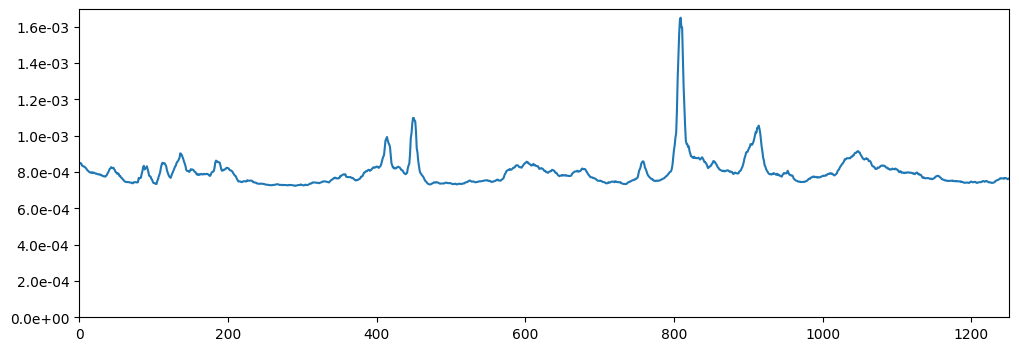

In [198]:
plt.figure(figsize=(12,4))
plt.plot(mask_out)
plt.xlim((0, 1251))
plt.ylim(bottom=0.)
plt.gca().set_yticklabels(['{:.1e}'.format(y) for y in plt.gca().get_yticks()])
plt.show()